Most common supervised learning tasks are regression (predicting values) and classification (predicting classes).
In Ch2, we explored a regression task, predicting housing values, using various algorithms such as linear regression, decision trees and random forests.

Now we will turn our attention to classification systems.

**MNIST**
MNIST dataset is a set of 70000 small images of digits handwritten by highschool students and employees of the US census bureau.

In [2]:
from sklearn.datasets import fetch_openml

# by default returns inputs as a Pandas DF and labels as
# a Pandas series (unless the dataset is sparse)
# but the MNIST dataset contains images, and DFs arent ideal for that
# so we set 'as_frame=False' to get the data as NumPy arrays instead
mnist = fetch_openml('mnist_784', as_frame=False)

The sklearn.datasets package contains mostly three types of functions:-
- fetch_functions such as fetch_openml() to download real-life datasets
- load_* functions to load small toy datasets bundled with Scikit-Learn (so they don’t need to be downloaded over the internet)
- make_* functions to generate fake datasets, useful for tests

In [3]:
# Generated datasets are usually returned as an (X, y) tuple of 
# 'data' - the input data, 2D NumPy array
# 'target' - the labels, usually as a 1D NumPy array
# we can deconstruct it as
X, y = mnist.data, mnist.target
print(X)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [4]:
print(X.shape) # (70000, 784)
print(y)

(70000, 784)
['5' '0' '4' ... '4' '5' '6']


In [5]:
print(y.shape)

(70000,)


There are 70000 images and each image has 784 features. This is because each image is 28 x 28 pixels (each pixel is a feature, and each has an intensity from 0 (white) to 255 (black)).

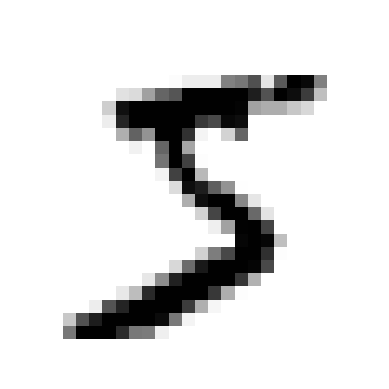

In [6]:
# lets take a peek at one digit from the dataset
# All we need to do is grab an instance's feature vector
# reshape it to a 28 x 28 array, and display it using imshow()
# We use cmap="binary" to get a grayscale color map where 0 is white
# and 255 is black
import matplotlib.pyplot as plt

def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

some_digit = X[0]
plot_digit(some_digit)
plt.show()

In [7]:
# looks like a 5, and this is indeed what the label tells us
y[0]

'5'

In [8]:
# MNIST dataset is already split into a training set
# the first 60000 images are training
# the last 10000 images are test

In [9]:
X_train, y_train, X_test, y_test = X[:60000], y[:60000], X[:10000], y[:10000]

# the training set is already shuffled for us which is important

**Training a Binary Classifier**
Lets simplify the problem for now and only try to identify one digit.
The 5_detector will be an example of a binary classifier,
capable of distinguishing between 2 classes
5 and non-5

In [10]:
# first we'll create the target vectors for this classification task
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

In [11]:
# lets start with SGD classifier (stochastic gradient descent)
# its capable of handling large datasets efficiently
# This is in part because SGD deals with training instances separately
# This is also what makes SGD well-suited for online learning
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

# lets test it
sgd_clf.predict([some_digit])

array([ True])

**Performance Measures**
Evaluating a classifier is often trickier than evaluating a regressor.

**Measuring accuracy using Cross-validation**
A good way to evaluate a model is to use cross-validation (just as we did in Chapter 2).
Lets use the `cross_val_score()` function, using k-fold cross validation with three fields
Remember that k-fold cross validation splits the training set into `k` folds (in this case 3) and then trains the model `k` times, holding out a different fold each time for evaluation

In [12]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

Wow above 95% accuracy (ratio of correct predictions) on all cross-validation folds? 
Well, before you get too excited, let’s look at a dummy
classifier that just classifies every single image in the most frequent class, which in this case is the negative class (i.e., non 5):

In [13]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
# prints False: no 5s detected
print(any(dummy_clf.predict(X_train)))

False


In [14]:
# Can you guess this model’s accuracy? Let’s find out:
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.90965, 0.90965, 0.90965])

That’s right, it has over 90% accuracy! This is simply because only about 10% of the images are 5s, so if you always guess that an image is not a 5, you will be right about 90% of the time. Beats Nostradamus.

This demonstrates why accuracy is generally not the preferred performance measure for classifiers, especially when you are dealing with skewed datasets (i.e. when some classes are more frequent than others)

A much better way to evaluate the performance of a classifier is to look at the confusion matrix (CM).

**Confusion matrices**

The general idea of a confusion matrix is to count the number of times instances of class A are classified as class B, for all A/B pairs. 
For example, to know the number of times the classifier confused images of 8s with 0s, you would look at row #8, column #0 of the confusion matrix

To compute the confusion matrix, you first need to have a set of predictions so that they can be compared to the actual targets. You could make predictions on the test set, but it’s best to keep that untouched for now (remember that you want to use the test set only at the very end of your project, once you have a classifier that you are ready to launch). 

Instead, you can use the cross_val_predict() function

In [15]:
from sklearn.model_selection import cross_val_predict

# Just like the cross_val_score() function, cross_val_predict()
# performs k-fold cross-validation, but instead of returning the
# evaluation scores,
# it returns the predictions made on each test fold.
# This means that you get a clean prediction for each instance in
# the training set 
# (by “clean” I mean “out-of-sample”: the model makes predictions on
# data that it never saw during training).
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [16]:
from sklearn.metrics import confusion_matrix

# Each row in a confusion matrix represents an actual class,
# while each column represents a predicted class
cm = confusion_matrix(y_train_5, y_train_pred)

cm

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

The first row of this matrix considers non-5 images (the
negative class): 53,892 of them were correctly classified as non-5s (they are called true
negatives), while the remaining 687 were wrongly classified as 5s (false positives, also called type I errors). 

The second row considers the images of 5s (the positive class):
1,891 were wrongly classified as non-5s (false negatives, also called type II errors),
while the remaining 3,530 were correctly classified as 5s (true positives).

In [17]:
# A perfect classifier would only have true positives and true negatives, 
# so its confusion matrix would have nonzero values
# only on its main diagonal (top left to bottom right)
y_train_perfect_predictions = y_train_5 # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

The confusion matrix gives you a lot of information, but sometimes you may prefer a more concise metric.
An interesting one to look at is the accuracy of the positive
predictions; this is called the `precision` of the classifier

precision = TP / (TP + FP)

`TP` is the number of true positives
`FP` is the number of false positives

A trivial way to have perfect precision is to create a classifier that always makes negative predictions, except for one single positive prediction on the instance it's most confident about.

If this one prediction is correct, then the classifier has 100% precision (precision = 1/1 = 100%).

Obviously, such a classifier would not be very useful, since it would ignore all but one positive instance. So, precision is typically used along with another metric named recall, also called sensitivity or the true positive rate (TPR):

recall = TP / (TP + FN)

`FN` is the number of false negatives


In [18]:
# Precision and Recall

from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [19]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

Now our 5-detector does not look as accurate. When it claims an image represents a 5, it is only correct 83.7% of the time. Also it only detects 65.1% of the 5s.

It is often convenient to combine precision and recall into a single metric called the F1 score. The F1 scire is the `harmonic mean` of precision and recall. Whereas the regular mean treats all values equally, the harmonic mean gives much more weight to low values. As a result, the classifier will only get a high F1 score if both recall and precision are high.


F1 = 2 * ((precision * recall) / (precision + recall))

In [20]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

The F1 score favors classifiers that have similar precision and recall. This is not always what you want: in some contexts you mostly care about precision, and in other contexts you really care about recall.

For e.g. if you trained a classifier to detect videos that are safe for kids, youre ok with a classifier that rejects many good videos (low recall) and keeps only safe ones (high precision). A high recall would allow really bad videos to show up in the product (in such cases we may even want a human pipeline to check the classifiers video selection).

On the other hand, suppose you train a classifier to detect shoplifters in surveillance images: it is probably fine if your classifier only has 30% precision as long as it has 99% recall (sure, the security guards will get a few false alerts, but almost all shoplifters will get caught).

Unfortunately, you can’t have it both ways: increasing precision reduces recall, and vice versa. This is called the precision/recall trade-off.

**The Precision/Recall Trade-off**
See figure 3-4 for details

In [21]:
# Scikit-Learn does not let you set the threshold directly,
# but it does give you access to
# the decision scores that it uses to make predictions.
# Instead of calling the classifier’s predict() method, you can call its
# decision_function() method, which returns a
# score for each instance, and then use any threshold you want to make
# predictions based on those scores:

y_scores = sgd_clf.decision_function([some_digit])
threshold = 3000

In [22]:
# How do you decide which threshold to use? First, use the cross_val_predict()
# function to get the scores of all instances in the training set, but this time specify that
# you want to return decision scores instead of predictions:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [23]:
# With these scores, use the precision_recall_curve() function to compute precision
# and recall for all possible thresholds (the function adds a last precision of 0 and a last
# recall of 1, corresponding to an infinite threshold):
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

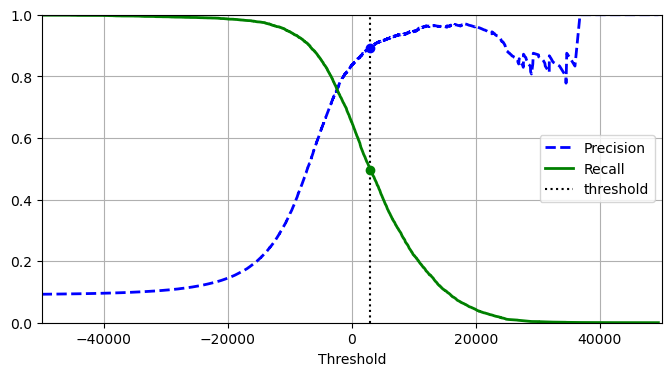

In [25]:
plt.figure(figsize=(8, 4))  # extra code – it's not needed, just formatting
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")

# extra code – this section just beautifies and saves Figure 3–5
idx = (thresholds >= threshold).argmax()  # first index ≥ threshold
plt.plot(thresholds[idx], precisions[idx], "bo")
plt.plot(thresholds[idx], recalls[idx], "go")
plt.axis([-50000, 50000, 0, 1])
plt.grid()
plt.xlabel("Threshold")
plt.legend(loc="center right")
# save_fig("precision_recall_vs_threshold_plot")

plt.show()

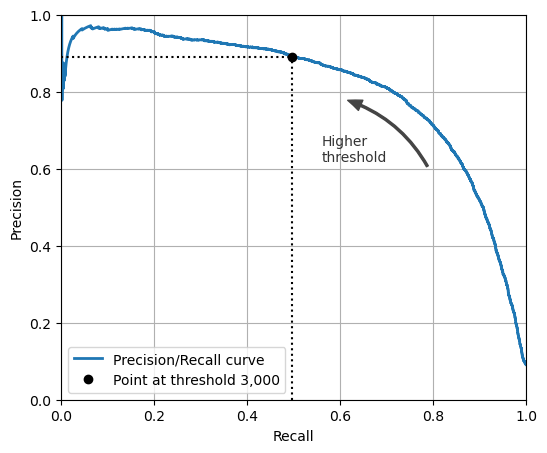

In [26]:
# Another way to select a good precision/recall trade-off is to plot precision
# directly against recall

# plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")
# plt.show() # Y is precision, X is recall
import matplotlib.patches as patches  # extra code – for the curved arrow

plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting

plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")

# extra code – just beautifies and saves Figure 3–6
plt.plot([recalls[idx], recalls[idx]], [0., precisions[idx]], "k:")
plt.plot([0.0, recalls[idx]], [precisions[idx], precisions[idx]], "k:")
plt.plot([recalls[idx]], [precisions[idx]], "ko",
         label="Point at threshold 3,000")
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.79, 0.60), (0.61, 0.78),
    connectionstyle="arc3,rad=.2",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.56, 0.62, "Higher\nthreshold", color="#333333")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")

plt.show()
# you can see thatprecision starts to drop off around 80% recall
# so you probably want to select a precision/recall tradeoff just before that drop
# for example at around 60% recall, but the choice depends on your project

Suppose you decide to aim for 90% precision. You could use the first plot to find the threshold you need to use, but that’s not very precise. Alternatively, you can search for the lowest threshold that gives you at least 90% precision.

In [28]:
# For this, you can use the NumPy array’s argmax() method.
# This returns the first index of the maximum value, which in this case
# means the first True value
idx_for_90_precision = (precisions >= 0.90).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

3370.019499143957

In [29]:
y_train_pred_90 = (y_scores >= threshold_for_90_precision)
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [30]:
recall_at_90_precision = recall_score(y_train_5, y_train_pred_90)
recall_at_90_precision

0.4799852425751706

TODO ROC curve...
TODO When to use ROC vs Precision/Recall curve...

**Multiclass Classification**

Used to distinguish between > 2 classes. Some sk classifiers can handle multiple classes natively (LogisticRegression, RandomForestClassifier and GaussianNB). For binary classifiers we need to employ a strategy:-

OVO - for N classes, need to train N x (N-1) / 2 classifiers (for MNIST, this means 45 classifiers)

OVR - for N classes, need to train N classifiers and select the class whose classifier has the highest score

In [27]:
# Scikit-Learn detects when you try to use a binary classification algorithm for
# a multiclass classification task, and it automatically runs OvR or OvO,
# depending on the algorithm. Let’s try this with a support vector machine
# classifier using the sklearn.svm.SVC class (see Chapter 5). We’ll only train
# on the first 2,000 images, or else it will take a very long time:
from sklearn.svm import SVC

svm_clf = SVC(random_state=42)
svm_clf.fit(X_train[:2000], y_train[:2000]) # y_train, not y_train_5

SVC(random_state=42)

That was easy! We trained the SVC using the original target classes from 0 to 9 (y_train), instead of the 5-versus-the-rest target classes (y_train_5). Since there are 10 classes (i.e., more than 2), Scikit-Learn used the OvO strategy and trained 45 binary classifiers.

In [ ]:
# Now let’s make a prediction on an image
svm_clf.predict([some_digit])

That’s correct! This code actually made 45 predictions—one per pair of classes—and it selected the class that won the most duels.

In [ ]:
# If you call the decision_function() method, you will see that it returns 
# 10 scores per instance: one per class. Each class gets a score equal to the
# number of won duels plus or minus a small tweak (max ±0.33) to break ties,
# based on the classifier scores
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores.round(2)

In [ ]:
# The highest score is 9.3, and it’s indeed the one corresponding to class 5:
class_id = some_digit_scores.argmax()
class_id

In [ ]:
# When a classifier is trained, it stores the list of target classes in its
# classes_ attribute, ordered by value
# in the case of MNIST, the class id matches the lbel
# however you generally need to look up the label like this
svm_clf.classes_[class_id]

In [ ]:
# Training an SGDClassifier on a multiclass dataset and using it to make
# predictions is just as easy:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

In [ ]:
#Oops, that’s incorrect. Prediction errors do happen! This time Scikit-Learn
# used the OvR strategy under the hood: since there are 10 classes,
# it trained 10 binary classifiers. The decision_function() method now returns
# one value per class. Let’s look at the scores that the SGD classifier
# assigned to each class:
sgd_clf.decision_function([some_digit]).round()

You can see that the classifier is not very confident about its prediction: almost all scores are very negative (class3 and 5 are closer to positive)
As usual you can use the cross_val_score() to evaluate the model:

In [ ]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

It gets over 85.8% on all test folds. If you used a random classifier, you would get 10% accuracy, so this is not such a bad score, but you can still do much better. Simply scaling the inputs (as discussed in Chapter 2) increases accuracy above 89.1%:

In [32]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype("float64"))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

**Error Analysis**


If this were a real project, you would now follow the steps in your machine learning project checklist (see Appendix A). 
You’d explore data preparation options, try out multiple models, shortlist the best ones, fine-tune their hyperparameters using GridSearchCV, and automate as much as possible.

Here, we will assume that you have found a promising model and you want to find ways to improve it. One way to do this is to analyze the types of errors it makes.

In [31]:
# First, look at the confusion matrix. For this, you first need to make predictions using
# the cross_val_predict() function; then you can pass the labels and predictions to
# the confusion_matrix() function, just like you did earlier. However, since there are
# now 10 classes instead of 2, the confusion matrix will contain quite a lot of numbers,
# and it may be hard to read.
# A colored diagram of the confusion matrix is much easier to analyze. To plot such a
# diagram, use the ConfusionMatrixDisplay.from_predictions() function like this:

from sklearn.metrics import ConfusionMatrixDisplay
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)
plt.show()

NameError: name 'X_train_scaled' is not defined